In [1]:
import numpy as np
import pandas as pd 
import nltk

import os



In [2]:
import re
import string   
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\4jasv\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-

In [3]:
columns = ["Id","Entity","Target","Text"]
data = pd.read_csv("train_test/twitter_training.csv",
                   names=columns,header=None)

In [4]:
data.head()

,Id,Entity,Target,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
df = data[["Text","Target"]]

In [6]:
df.head()

,Text,Target
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive


In [7]:
df.shape

(74682, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    73996 non-null  object
 1   Target  74682 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [9]:
df= df.drop_duplicates()

<AxesSubplot:xlabel='Target', ylabel='count'>

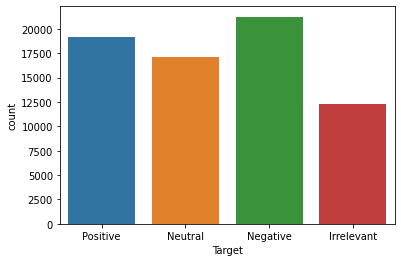

In [10]:
sns.countplot(x="Target",data=df)

In [11]:
sentiment = []

for i in df["Target"]:
    if i == "Positive":
        sentiment.append(1)
    elif (i == "Irrelevant") or (i == "Neutral"):
        sentiment.append(0)
    else:
        sentiment.append(-1)
df["Sentiment"] = sentiment

In [12]:
df.head()

,Text,Target,Sentiment
0,im getting on borderlands and i will murder yo...,Positive,1
1,I am coming to the borders and I will kill you...,Positive,1
2,im getting on borderlands and i will kill you ...,Positive,1
3,im coming on borderlands and i will murder you...,Positive,1
4,im getting on borderlands 2 and i will murder ...,Positive,1


In [13]:
stop_words = set(stopwords.words("english"))

## Text Cleaner

In [14]:
df["Text"] = df["Text"].str.replace("\d","")

In [15]:
def cleaner(data):
    # Tokens
    tokens = word_tokenize(str(data).replace("'", "").lower()) 
    
    # Remove Puncs
    without_punc = [w for w in tokens if w.isalpha()]
    
    # Stopwords
    without_sw = [t for t in without_punc if t not in stop_words]
    
    # Lemmatize
    text_len = [WordNetLemmatizer().lemmatize(t) for t in without_sw]
    # Stem
    text_cleaned = [PorterStemmer().stem(w) for w in text_len]
    
    return " ".join(text_cleaned)

In [16]:
df["Text"] = df["Text"].apply(cleaner)
df["Text"].head()

0     im get borderland murder
1             come border kill
2       im get borderland kill
3    im come borderland murder
4     im get borderland murder
Name: Text, dtype: object

In [17]:
df["Text"]=df["Text"].str.replace("im","")
df["Text"].head()

0      get borderland murder
1           come border kill
2        get borderland kill
3     come borderland murder
4      get borderland murder
Name: Text, dtype: object

## Rare Words

In [18]:
rare_words = pd.Series(" ".join(df["Text"]).split()).value_counts()
rare_words

game                                                                                                                                                                                                                                                                                                                                                                                              10787
play                                                                                                                                                                                                                                                                                                                                                                                               6822
get                                                                                                                                                                                                                     

In [19]:
rare_words = rare_words[rare_words <= 2]

In [20]:
df["Text"] = df["Text"].apply(lambda x: " ".join([i for i in x.split() if i not in rare_words.index]))

In [21]:
type(df)

pandas.core.frame.DataFrame

## Word Cloud

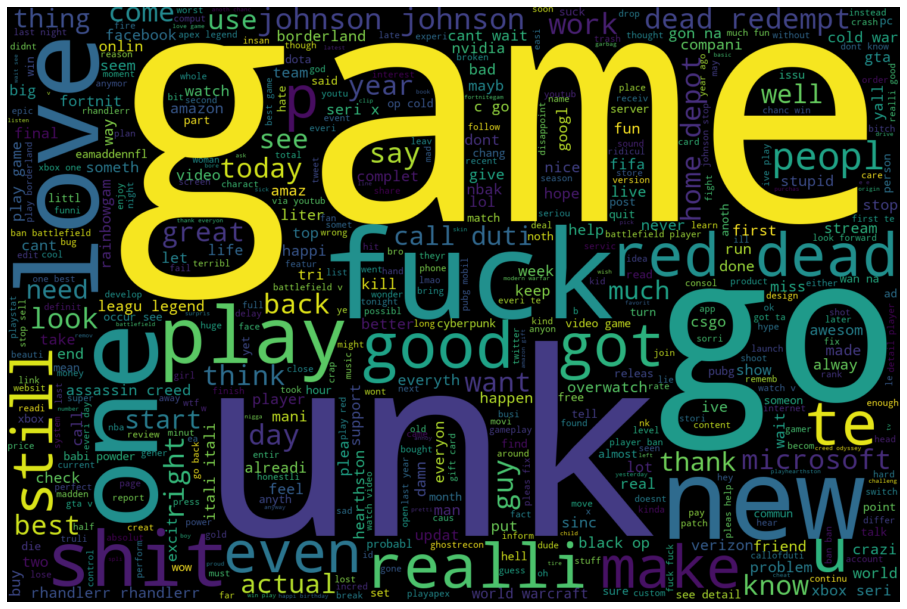

In [22]:
plt.figure(figsize=(16,12))
wordcloud = WordCloud(background_color="black",max_words=500, width=1500, height=1000).generate(' '.join(df['Text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Train test split

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.ensemble import RandomForestClassifier

In [24]:
X = df["Text"]
y = df["Sentiment"]
type(X)

pandas.core.series.Series

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.30,random_state= 42)
type(X_train)

pandas.core.series.Series

## Count Vectorizer

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(X_train)
X_test_count = vt.transform(X_test)

In [28]:
print(X_train)

16737                             ha ha best exampl indian
6937     one saddest day life chief execut queen reflec...
35935       use new microsoft edg final quit chrome beebom
73337    nvidia new driver give major game free thank vrss
72330    ubisoft ghostrecon updat suppos help peopl bad...
                               ...                        
39820               holi shit play battlefield game heaven
6597     cop control specif speak experi theyr good tes...
58811                kid deserv life tweet websit facebook
891                       unpopular opinion none game good
16795    dont let anyon blame want spend money shoe wor...
Name: Text, Length: 48841, dtype: object


In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df_hybrid=pd.DataFrame(X_train)
df_hybrid['nltk_scores']=df_hybrid['Text'].apply(lambda x: sia.polarity_scores(x))
df_hybrid['nltk_cmp_score'] = df_hybrid['nltk_scores'].apply(lambda score_dict: score_dict['compound'])

neutral_thresh = 0.05
df_hybrid['nltk_sentiment'] = df_hybrid['nltk_cmp_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))
df_hybrid['nltk_cmp_score'].describe()
# nltk_sentiment_df = get_value_counts('nltk_sentiment','NLTK Vader')
# nltk_sentiment_df

count    48841.000000
mean         0.033228
std          0.500060
min         -0.989600
25%         -0.401900
50%          0.000000
75%          0.440400
max          0.995600
Name: nltk_cmp_score, dtype: float64

In [30]:
from textblob import TextBlob
df_hybrid['textblob_score'] = df_hybrid['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
neutral_thresh = 0.05
df_hybrid['textblob_sentiment'] = df_hybrid['textblob_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))
df_hybrid['textblob_score'].describe()

count    48841.000000
mean         0.040134
std          0.324472
min         -1.000000
25%         -0.070000
50%          0.000000
75%          0.175000
max          1.000000
Name: textblob_score, dtype: float64

In [31]:
import stanza
stanza.download('en')
nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')
def stanza_analyze(Text):
    document = nlp(Text)
    print('Processing')
    return np.mean([(i.sentiment - 1) for i in document.sentences]) 
df_hybrid['stanza_score'] = df_hybrid['Text'].apply(lambda x: stanza_analyze(x))
df_hybrid['stanza_score'].describe()
neutral_thresh = 0.05
df_hybrid['stanza_sentiment'] = df_hybrid['stanza_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))

2022-06-04 01:00:11 INFO: Downloading default packages for language: en (English)...
2022-06-04 01:00:13 INFO: File exists: C:\Users\4jasv\stanza_resources\en\default.zip.
2022-06-04 01:00:20 INFO: Finished downloading models and saved to C:\Users\4jasv\stanza_resources.
2022-06-04 01:00:20 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2022-06-04 01:00:20 INFO: Use device: cpu
2022-06-04 01:00:20 INFO: Loading: tokenize
2022-06-04 01:00:21 INFO: Loading: sentiment
2022-06-04 01:00:22 INFO: Done loading processors!


Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing
Processing

In [32]:
df_hybrid['nltk_cmp_score'] = df_hybrid['nltk_scores'].apply(lambda score_dict: score_dict['compound'])
df_hybrid['nltk_scores']

16737    {'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...
6937     {'neg': 0.214, 'neu': 0.695, 'pos': 0.091, 'co...
35935    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
73337    {'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'comp...
72330    {'neg': 0.209, 'neu': 0.614, 'pos': 0.177, 'co...
                               ...                        
39820    {'neg': 0.446, 'neu': 0.144, 'pos': 0.41, 'com...
6597     {'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'comp...
58811    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
891      {'neg': 0.376, 'neu': 0.624, 'pos': 0.0, 'comp...
16795    {'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'comp...
Name: nltk_scores, Length: 48841, dtype: object

In [33]:
df_hybrid.head()

,Text,nltk_scores,nltk_cmp_score,nltk_sentiment,textblob_score,textblob_sentiment,stanza_score,stanza_sentiment
16737,ha ha best exampl indian,"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.8402,Positive,1.000000,Positive,1.0,Positive
6937,one saddest day life chief execut queen reflec...,"{'neg': 0.214, 'neu': 0.695, 'pos': 0.091, 'co...",-0.5106,Negative,0.000000,Neutral,0.0,Neutral
35935,use new microsoft edg final quit chrome beebom,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,0.068182,Positive,-1.0,Negative
73337,nvidia new driver give major game free thank vrss,"{'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'comp...",0.7003,Positive,0.049716,Neutral,1.0,Positive
72330,ubisoft ghostrecon updat suppos help peopl bad...,"{'neg': 0.209, 'neu': 0.614, 'pos': 0.177, 'co...",-0.2263,Negative,-0.200000,Negative,-1.0,Negative


In [34]:
sentiment = []

for i in df_hybrid["nltk_sentiment"]:
    if i == "Positive":
        sentiment.append(1)
    elif (i == "Irrelevant") or (i == "Neutral"):
        sentiment.append(0)
    else:
        sentiment.append(-1)
df_hybrid['nltk_cmp_sentiment'] = sentiment

In [35]:
sentiment = []

for i in df_hybrid["textblob_sentiment"]:
    if i == "Positive":
        sentiment.append(1)
    elif (i == "Irrelevant") or (i == "Neutral"):
        sentiment.append(0)
    else:
        sentiment.append(-1)
df_hybrid['textblob_cmp_sentiment'] = sentiment

In [36]:
sentiment = []

for i in df_hybrid["stanza_score"]:
    if i == 1.0:
        sentiment.append(1)
    elif i==-1.0:
        sentiment.append(-1)
    else:
        sentiment.append(0)
df_hybrid['stanza_cmp_sentiment'] = sentiment

In [37]:
df_hybrid.head()

,Text,nltk_scores,nltk_cmp_score,nltk_sentiment,textblob_score,textblob_sentiment,stanza_score,stanza_sentiment,nltk_cmp_sentiment,textblob_cmp_sentiment,stanza_cmp_sentiment
16737,ha ha best exampl indian,"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.8402,Positive,1.000000,Positive,1.0,Positive,1,1,1
6937,one saddest day life chief execut queen reflec...,"{'neg': 0.214, 'neu': 0.695, 'pos': 0.091, 'co...",-0.5106,Negative,0.000000,Neutral,0.0,Neutral,-1,0,0
35935,use new microsoft edg final quit chrome beebom,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,0.068182,Positive,-1.0,Negative,0,1,-1
73337,nvidia new driver give major game free thank vrss,"{'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'comp...",0.7003,Positive,0.049716,Neutral,1.0,Positive,1,0,1
72330,ubisoft ghostrecon updat suppos help peopl bad...,"{'neg': 0.209, 'neu': 0.614, 'pos': 0.177, 'co...",-0.2263,Negative,-0.200000,Negative,-1.0,Negative,-1,-1,-1


In [38]:
print(X_train_count.toarray())
X_train_count

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<48841x14117 sparse matrix of type '<class 'numpy.int64'>'
	with 481457 stored elements in Compressed Sparse Row format>

## MultinomialNB

In [39]:
nb_model = MultinomialNB()
nb_model.fit(X_train_count,y_train,)

MultinomialNB()

In [40]:
print(y_train)

16737    0
6937    -1
35935    0
73337    0
72330   -1
        ..
39820    1
6597     0
58811    0
891      0
16795    1
Name: Sentiment, Length: 48841, dtype: int64


In [41]:
nb_pred = nb_model.predict(X_test_count)
nb_train_pred = nb_model.predict(X_train_count)

X Test
              precision    recall  f1-score   support

          -1       0.72      0.77      0.75      6355
           0       0.77      0.71      0.74      8793
           1       0.69      0.73      0.71      5784

    accuracy                           0.73     20932
   macro avg       0.73      0.74      0.73     20932
weighted avg       0.73      0.73      0.73     20932

X Train
              precision    recall  f1-score   support

          -1       0.76      0.81      0.78     14883
           0       0.81      0.75      0.78     20603
           1       0.74      0.77      0.75     13355

    accuracy                           0.77     48841
   macro avg       0.77      0.78      0.77     48841
weighted avg       0.78      0.77      0.77     48841



<AxesSubplot:>

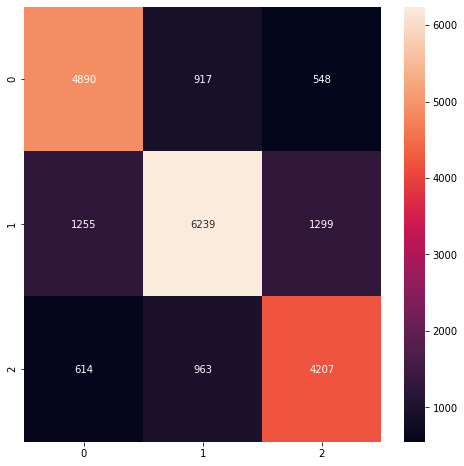

In [42]:
print("X Test")
print(classification_report(y_test,nb_pred))
print("X Train")
print(classification_report(y_train,nb_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,nb_pred),annot = True,fmt = "d")

In [43]:
from yellowbrick.classifier import PrecisionRecallCurve

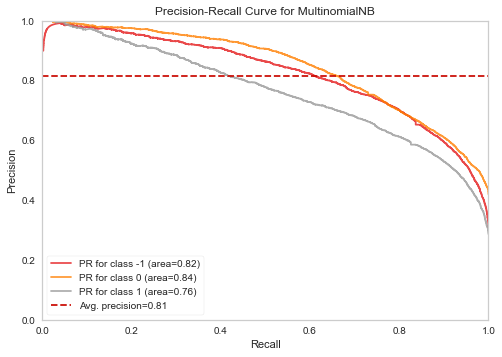

In [44]:
viz = PrecisionRecallCurve(MultinomialNB(),
                           classes=nb_model.classes_,    
                           per_class=True,  
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test) 
viz.show();

## Random Forest

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
rf_params = {"max_depth": [2,4,6,10,12],
            "max_features": [2,5,7],
            "n_estimators":[12,15,16,]}
rf = RandomForestClassifier()

In [47]:
rf_model_cv = GridSearchCV(rf,rf_params,cv = 5,n_jobs = -1)

In [48]:
# rf_model_cv.fit(X_train_count,y_train)
rf_model_cv.fit(X_train_count,y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 10, 12],
                         'max_features': [2, 5, 7],
                         'n_estimators': [12, 15, 16]})

In [49]:
rf_model_cv.best_params_

{'max_depth': 12, 'max_features': 7, 'n_estimators': 16}

In [50]:
rf_tuned = RandomForestClassifier(max_depth = 12,
                                 max_features = 7,
                                 min_samples_split = 2).fit(X_train_count,y_train)

In [51]:
rf_pred = rf_tuned.predict(X_test_count)
rf_train_pred = rf_tuned.predict(X_train_count)

X Test
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      6355
           0       0.42      1.00      0.59      8793
           1       0.00      0.00      0.00      5784

    accuracy                           0.42     20932
   macro avg       0.14      0.33      0.20     20932
weighted avg       0.18      0.42      0.25     20932

X Train
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     14883
           0       0.42      1.00      0.59     20603
           1       0.00      0.00      0.00     13355

    accuracy                           0.42     48841
   macro avg       0.14      0.33      0.20     48841
weighted avg       0.18      0.42      0.25     48841



<AxesSubplot:>

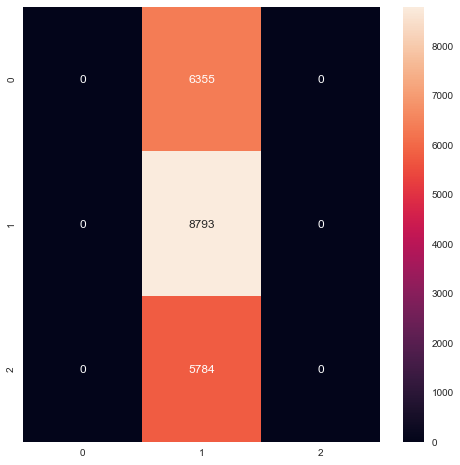

In [52]:
print("X Test")
print(classification_report(y_test,rf_pred))
print("X Train")
print(classification_report(y_train,rf_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,rf_pred),annot = True,fmt = "d")

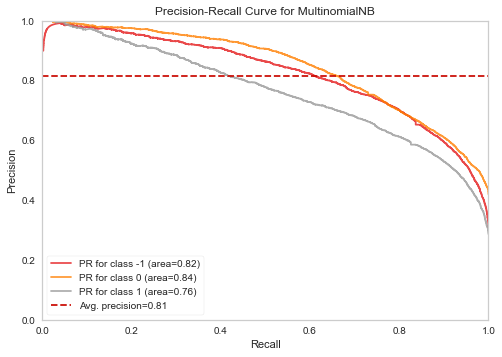

In [53]:
viz = PrecisionRecallCurve(MultinomialNB(),
                           classes=rf_tuned.classes_,
                           per_class=True,
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

## KNN

In [54]:
from sklearn.neighbors import KNeighborsClassifier

In [55]:
knn = KNeighborsClassifier()

In [56]:
knn_model = knn.fit(X_train_count,y_train)

In [57]:
knn_pred = knn_model.predict(X_test_count)
knn_train_pred = knn_model.predict(X_train_count)

In [58]:
y_testh=y_train

X Test
              precision    recall  f1-score   support

          -1       0.83      0.87      0.85      6355
           0       0.85      0.83      0.84      8793
           1       0.83      0.81      0.82      5784

    accuracy                           0.84     20932
   macro avg       0.84      0.84      0.84     20932
weighted avg       0.84      0.84      0.84     20932

X Train
              precision    recall  f1-score   support

          -1       0.92      0.94      0.93     14883
           0       0.93      0.92      0.92     20603
           1       0.92      0.90      0.91     13355

    accuracy                           0.92     48841
   macro avg       0.92      0.92      0.92     48841
weighted avg       0.92      0.92      0.92     48841



<AxesSubplot:>

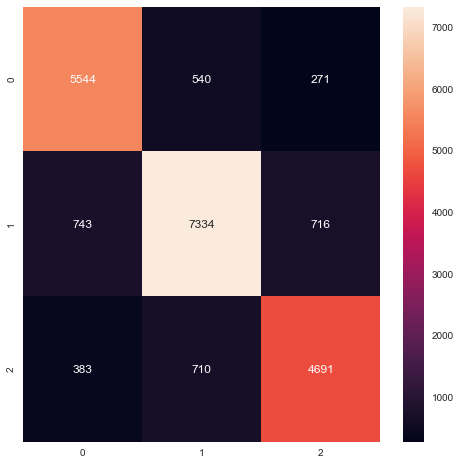

In [59]:
print("X Test")
print(classification_report(y_test,knn_pred))
print("X Train")
print(classification_report(y_train,knn_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,knn_pred),annot = True,fmt = "d")


In [60]:
df_hybrid['knn_cmp_sentiment']=knn_train_pred

In [61]:
type(knn_pred)

numpy.ndarray

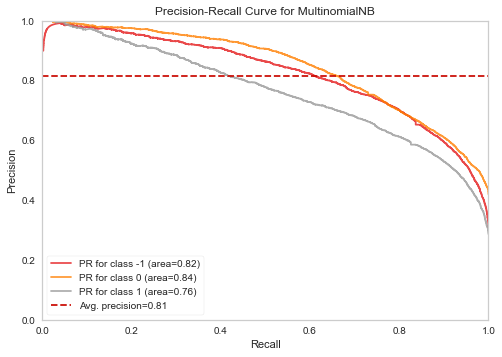

In [62]:
viz = PrecisionRecallCurve(MultinomialNB(),
                           classes=knn_model.classes_,
                           per_class=True,
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [63]:
from sklearn.svm import SVC

In [64]:
svc_model = SVC().fit(X_train_count,y_train)

In [65]:
svc_pred = svc_model.predict(X_test_count)
svc_train_pred = svc_model.predict(X_train_count)


In [66]:
print(svc_pred)

[-1  0  0 ...  0 -1 -1]


X Test
              precision    recall  f1-score   support

          -1       0.90      0.85      0.87      6355
           0       0.83      0.91      0.86      8793
           1       0.88      0.80      0.84      5784

    accuracy                           0.86     20932
   macro avg       0.87      0.85      0.86     20932
weighted avg       0.86      0.86      0.86     20932

X Train
              precision    recall  f1-score   support

          -1       0.94      0.90      0.92     14883
           0       0.89      0.95      0.92     20603
           1       0.93      0.88      0.90     13355

    accuracy                           0.92     48841
   macro avg       0.92      0.91      0.92     48841
weighted avg       0.92      0.92      0.92     48841



<AxesSubplot:>

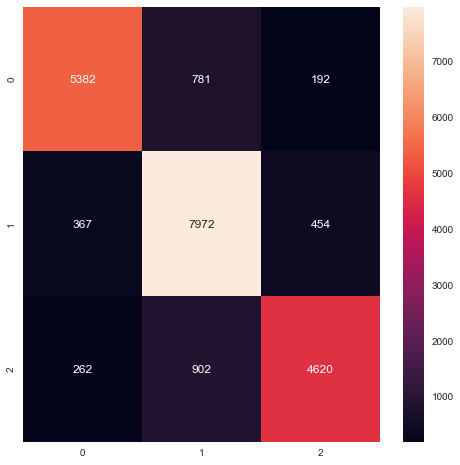

In [67]:
print("X Test")
print(classification_report(y_test,svc_pred))
print("X Train")
print(classification_report(y_train,svc_train_pred))

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test,svc_pred),annot = True,fmt = "d")


In [89]:
# df_hybrid['svc_cmp_sentiment']=svc_pred

In [69]:
df_hybrid.head()

,Text,nltk_scores,nltk_cmp_score,nltk_sentiment,textblob_score,textblob_sentiment,stanza_score,stanza_sentiment,nltk_cmp_sentiment,textblob_cmp_sentiment,stanza_cmp_sentiment,knn_cmp_sentiment
16737,ha ha best exampl indian,"{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'comp...",0.8402,Positive,1.000000,Positive,1.0,Positive,1,1,1,0
6937,one saddest day life chief execut queen reflec...,"{'neg': 0.214, 'neu': 0.695, 'pos': 0.091, 'co...",-0.5106,Negative,0.000000,Neutral,0.0,Neutral,-1,0,0,-1
35935,use new microsoft edg final quit chrome beebom,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral,0.068182,Positive,-1.0,Negative,0,1,-1,-1
73337,nvidia new driver give major game free thank vrss,"{'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'comp...",0.7003,Positive,0.049716,Neutral,1.0,Positive,1,0,1,0
72330,ubisoft ghostrecon updat suppos help peopl bad...,"{'neg': 0.209, 'neu': 0.614, 'pos': 0.177, 'co...",-0.2263,Negative,-0.200000,Negative,-1.0,Negative,-1,-1,-1,-1


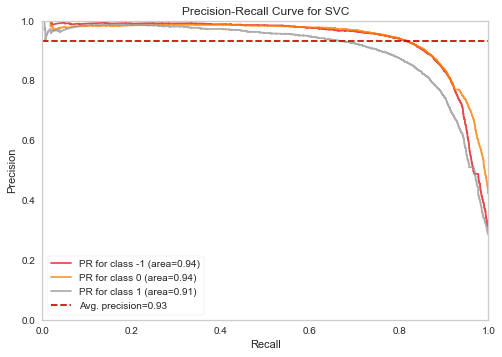

In [70]:
viz = PrecisionRecallCurve(SVC(),
                           classes=svc_model.classes_,
                           per_class=True,
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [85]:


train_pred = pd.DataFrame({"MultinomialNB":[accuracy_score(y_train,nb_train_pred)],
                      "Random Forest": [accuracy_score(y_train,rf_train_pred)],
                      "KNN": [accuracy_score(y_train,knn_train_pred)],
                       "SVC": [accuracy_score(y_train,svc_train_pred)],
                       
                       
                       })

<AxesSubplot:>

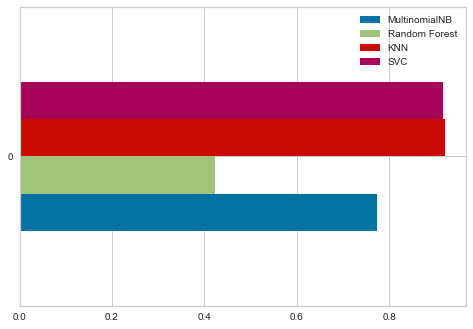

In [86]:
train_pred.plot(kind="barh")

In [78]:
accuracy_score(y_test,svc_pred)

0.858685266577489

In [79]:
df_hybrid['knn_cmp_sentiment']=knn_train_pred
df_hybrid['svc_cmp_sentiment']=svc_train_pred

In [80]:
df_hybrid['sentiment_votes'] =  df_hybrid.apply(lambda x: list([ x['textblob_cmp_sentiment'],
                                                                x['knn_cmp_sentiment'],
                                                                x['svc_cmp_sentiment']]),axis=1)

In [81]:
def get_most_voted_senti(List):
    if len(List) == len(set(List)): 
        return 0
    else:
        return max(set(List), key = List.count)


In [82]:
df_hybrid['composite_vote'] = df_hybrid['sentiment_votes'].apply(lambda x: get_most_voted_senti(x))

In [87]:
pred_df = pd.DataFrame({"MultinomialNB":[accuracy_score(y_test,nb_pred)],
                      "Random Forest": [accuracy_score(y_test,rf_pred)],
                      "KNN": [accuracy_score(y_test,knn_pred)],
                       "SVC": [accuracy_score(y_test,svc_pred)],
                        "Hybrid":[accuracy_score(df_hybrid['composite_vote'],y_testh)],
                      })

<AxesSubplot:>

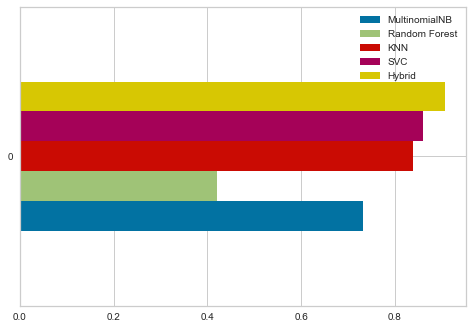

In [88]:
pred_df.plot(kind="barh")


In [83]:
accuracy_score(df_hybrid['composite_vote'],y_testh)

0.9062263262422964